In [1]:
from functools import partial

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import keras

from priors import rdm_prior_simple
from design import random_num_obs_discrete
from simulation import rdm_experiment_simple, CustomSimulator, batch_simulator

from bayesflow.utils import batched_call, tree_stack

import jax

from pymc_models import rdm_model_simple, RdmSimple

In [2]:
rng = np.random.default_rng()

In [3]:
prior_fun = partial(rdm_prior_simple, drift_intercept_loc=2,
    drift_intercept_scale=1,
    drift_slope_loc=2,
    drift_slope_scale=1,
    sd_true_shape=10,
    sd_true_scale=0.2,
    threshold_shape=10,
    threshold_scale=0.2,
    t0_loc=0.2,
    t0_scale=0.1,
    t0_lower=0,
    rng=rng)

In [4]:
num_obs_fun = partial(random_num_obs_discrete, values=[500], rng=rng)

In [5]:
simulator = CustomSimulator(
    prior_fun=prior_fun,
    design_fun=num_obs_fun,
    simulator_fun=partial(batch_simulator, simulator_fun=partial(rdm_experiment_simple, s_false=1, rng=rng)),
)

In [6]:
sample_data = simulator.sample((10,))

In [7]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['v_intercept', 'v_slope', 's_true', 'b', 't0', 'num_obs', 'x'])
Types of sample_data values:
	 {'v_intercept': <class 'numpy.ndarray'>, 'v_slope': <class 'numpy.ndarray'>, 's_true': <class 'numpy.ndarray'>, 'b': <class 'numpy.ndarray'>, 't0': <class 'numpy.ndarray'>, 'num_obs': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'v_intercept': (10, 1), 'v_slope': (10, 1), 's_true': (10, 1), 'b': (10, 1), 't0': (10, 1), 'num_obs': (10, 1), 'x': (10, 500, 2)}


In [8]:
class LogTransform(bf.adapters.transforms.ElementwiseTransform):
    def forward(self, data, **kwargs):
        return np.log(data)
    

    def inverse(self, data, **kwargs):
        return np.exp(data)

In [9]:
class Broadcast(bf.adapters.transforms.Transform):
    def __init__(self, keys, *, to: str, expand: str | int | tuple = "left", exclude: int | tuple = -1):
        super().__init__()
        self.keys = keys
        self.to = to

        if isinstance(expand, int):
            expand = (expand,)

        self.expand = expand

        if isinstance(exclude, int):
            exclude = (exclude,)

        self.exclude = exclude


    def forward(self, data, strict=True, **kwargs):
        if strict:
            target_shape = data[self.to].shape

            data = data.copy()

            for k in self.keys:
                # ensure that .shape is defined
                data[k] = np.asarray(data[k])
                len_diff = len(target_shape) - len(data[k].shape)

                if self.expand == "left":
                    data[k] = np.expand_dims(data[k], axis=tuple(np.arange(0, len_diff)))
                elif self.expand == "right":
                    data[k] = np.expand_dims(data[k], axis=tuple(-np.arange(1, len_diff + 1)))
                elif isinstance(self.expand, tuple):
                    if len(self.expand) is not len_diff:
                        raise ValueError("Length of `expand` must match the length difference of the involed arrays.")
                    data[k] = np.expand_dims(data[k], axis=self.expand)

                new_shape = target_shape
                if self.exclude is not None:
                    new_shape = np.array(new_shape, dtype=int)
                    old_shape = np.array(data[k].shape, dtype=int)
                    exclude = list(self.exclude)
                    new_shape[exclude] = old_shape[exclude]
                    new_shape = tuple(new_shape)

                data[k] = np.broadcast_to(data[k], new_shape)

        return data
    

    def inverse(self, data: dict[str, np.ndarray], **kwargs) -> dict[str, np.ndarray]:
        return data

In [10]:
inference_variables = ["x"]
inference_conditions = ["v_intercept", "v_slope", "s_true", "b", "t0"]

adapter = (bf.adapters.Adapter()
    # .to_array()
    # .convert_dtype("float64", "float32")
    .drop("num_obs")
    .concatenate(inference_variables, into="inference_variables")
    .concatenate(inference_conditions, into="inference_conditions")
    # .add_transform(bf.adapters.transforms.FilterTransform(transform_constructor=LogTransform, include="inference_conditions"))
    # .standardize()
    # .expand_dims("inference_conditions", axis=1)
    # .add_transform(Broadcast(keys=["inference_conditions"], to="inference_variables", expand=1))
    .broadcast("inference_conditions", to="inference_variables", expand=1)
)

In [11]:
# inference_network = bf.networks.FlowMatching(
#     subnet="mlp",
#     subnet_kwargs=dict(
#         widths=[256] * 3,
#         dropout=0.0,
#     ),
#     use_optimal_transport=False,
# )
inference_network = bf.networks.CouplingFlow()

In [12]:
approximator = bf.ContinuousApproximator(
    # summary_network=summary_network,
    inference_network=inference_network,
    adapter=adapter,
)

In [13]:
epochs = 5
num_batches = 500
batch_size = 64

In [14]:
initial_learning_rate = 0.001
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=num_batches*epochs,
    alpha=1e-8
)

optimizer = keras.optimizers.AdamW(learning_rate=scheduled_lr)

In [15]:
approximator.compile(optimizer)

In [16]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    # memory_budget="8 GiB",
    simulator=simulator
)

INFO:bayesflow:Building dataset from simulator instance of CustomSimulator.
INFO:bayesflow:Using 32 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 0.1136 - loss/inference_loss: 0.1136
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: -1.5891 - loss/inference_loss: -1.5891
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: -2.0882 - loss/inference_loss: -2.0882
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: -3.8149 - loss/inference_loss: -3.8149
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: -5.2158 - loss/inference_loss: -5.2158


In [17]:
test_data = simulator.sample((10,))
# del test_data["x"]

In [18]:
test_prior = np.log(np.moveaxis([val for key, val in test_data.items() if key in inference_conditions], [0, 1, 2], [2, 0, 1]))

In [19]:
test_prior.shape

(10, 1, 5)

In [20]:
sample_dict = {k: v for k, v in test_data.items() if k not in inference_variables}

In [21]:
# posterior_samples = approximator.sample(conditions=sample_dict, num_samples=100)

In [22]:
ll_nle = approximator.log_prob(test_data)

In [23]:
ll_fun_vec = np.vectorize(rdm_model_simple, signature="(m,n)->()")

In [25]:
ll_fun_batch = ll_fun_vec(test_data["x"])

2024-11-29 14:52:05.529487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 14:52:05.529519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 14:52:05.530527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 14:52:06.144505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [41]:
ll_ref = np.array([fun(theta) for fun, theta in zip(ll_fun_batch, test_prior.squeeze())])

In [36]:
ll_ref

array([-11839.49219687, -13407.88754464, -11864.21049972, -11965.98450338,
       -11971.34735786, -11288.03260741, -30722.43210926, -17347.13955573,
       -19317.89014884, -18205.41160617])

In [37]:
ll_nle.sum(axis=-1)

array([2941.4243 , 3361.857  , 3179.8574 , 3104.9    , 3199.5117 ,
       2567.304  ,  124.41373, 3233.4028 , 3469.7378 , 3391.796  ],
      dtype=float32)

In [38]:
ll_nle.sum(axis=1)-ll_ref

array([14780.91651328, 16769.74447824, 15044.06792159, 15070.88440573,
       15170.85907661, 13855.33656249, 30846.84583607, 20580.54238776,
       22787.62794181, 21597.20750461])

In [39]:
np.corrcoef(ll_ref, ll_nle.sum(axis=1))

array([[1.        , 0.74789225],
       [0.74789225, 1.        ]])

Text(0, 0.5, 'NLE likelihood')

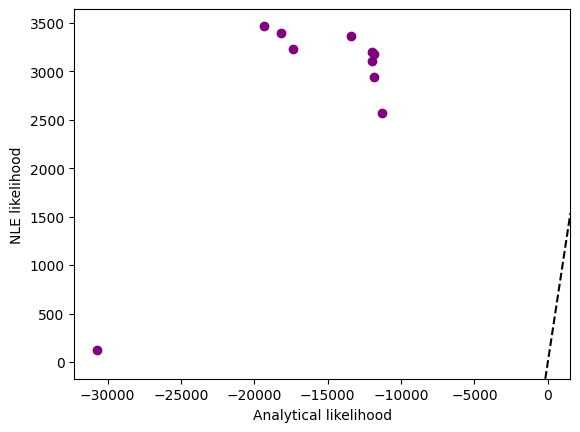

In [40]:
fig, ax = plt.subplots(1, 1)

ax.scatter(ll_ref, ll_nle.sum(axis=1), color="purple")
ax.axline([0, 0], slope=1, linestyle="--", color="black")
# ax.set_ylim((-1000, 3000))
ax.set_xlabel("Analytical likelihood")
ax.set_ylabel("NLE likelihood")

In [17]:
show_data = simulator.sample((1,), num_obs=10000)

In [18]:
show_prior = np.log(np.moveaxis([val for key, val in show_data.items() if key in inference_conditions], [0, 1, 2], [2, 0, 1]))

In [19]:
ll_nle_show = approximator.log_prob(show_data).squeeze()

In [113]:
rt = show_data["x"].squeeze()

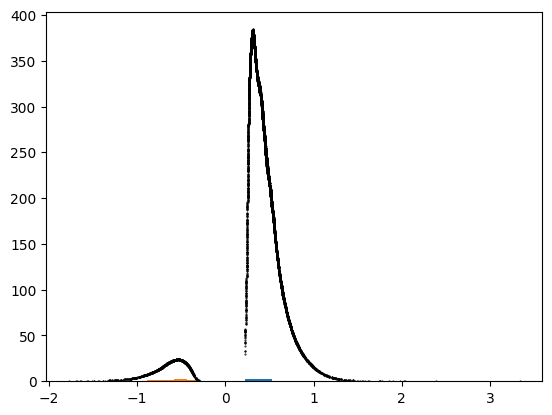

In [142]:
fig, ax = plt.subplots(1, 1)

ax.hist(rt[rt[:, 1] == 1, 0], density=True)
ax.hist(-rt[rt[:, 1] == 0, 0], density=True)

ax.scatter(rt[rt[:, 1] == 1, 0], np.exp(ll_nle_show[rt[:, 1] == 1]), color="black", s = 0.2)
ax.scatter(-rt[rt[:, 1] == 0, 0], np.exp(ll_nle_show[rt[:, 1] == 0]), color="black", s = 0.2)

In [17]:
from pymc_models import run_mcmc

import blackjax
import jax.numpy as jnp

In [18]:
test_data = simulator.sample((10,))
data = keras.tree.map_structure(keras.ops.convert_to_tensor, adapter(test_data, strict=True, stage="inference"))
data["inference_conditions"].shape

(10, 500, 5)

In [19]:
@jax.jit
def logdensity_fun(x, data):
    data["inference_conditions"] = jnp.tile(x, (1, 500, 1))

    return jnp.sum(approximator._log_prob(**data), axis=-1)

In [45]:
np.tile([2, 2, 1, 2, 0.2], [10, 1, 1]).shape

(10, 1, 5)

In [30]:
logdensity_fun(np.tile([2, 2, 1, 2, 0.2], [10, 1, 1]), data)

Array([ -6625.1895 , -32823.24   ,   2962.459  ,   -929.22546,
       -19381.926  ,   2413.026  ,   2578.3875 ,   2504.8037 ,
         2427.2937 ,   -951.4999 ], dtype=float32)

In [59]:
blackjax.adaptation.window_adaptation.AdaptationAlgorithm()

TypeError: AdaptationAlgorithm.__new__() missing 1 required positional argument: 'run'

In [53]:
adapt = blackjax.window_adaptation(blackjax.nuts, lambda x: logdensity_fun(x, data))
(last_state, parameters), _ = adapt.run(jax.random.PRNGKey(0), np.tile([2, 2, 1, 2, 0.2], [10, 1, 1]), num_steps=10)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (10,).

In [190]:
def build_kernels(n):
    return [blackjax.nuts.build_kernel() for _ in range(n)]


def multi_nuts(rng_key, state, parameters, kernels, data, n):
    sampling_keys = jax.random.split(rng_key, n)

    state = state.copy()

    init_positions = jnp.array([state[i].position for i in range(n)])[:, None, :]

    logdensities = logdensity_fun(init_positions, data)

    # jax.debug.print("{x}", x=logdensities[0])

    info = {}

    for i in range(n):
        def logd(x):
            return logdensities[i]
        state[i], info[i] = kernels[i](
            rng_key=sampling_keys[i],
            state=state[i],
            logdensity_fn=logd,
            step_size=parameters[i].step_size,
            inverse_mass_matrix=parameters[i].inverse_mass_matrix
        )
    
    return state, info

In [191]:
import blackjax.mcmc as mcmc
from blackjax.adaptation.base import AdaptationResults, return_all_adapt_info
from blackjax.adaptation.mass_matrix import (
    MassMatrixAdaptationState,
    mass_matrix_adaptation,
)
from blackjax.adaptation.step_size import (
    DualAveragingAdaptationState,
    dual_averaging_adaptation,
)
from blackjax.base import AdaptationAlgorithm
from blackjax.progress_bar import gen_scan_fn
from blackjax.types import Array, ArrayLikeTree, PRNGKey
from blackjax.util import pytree_size

def window_adaptation(
    n,
    data,
    is_mass_matrix_diagonal: bool = True,
    initial_step_size: float = 1.0,
    target_acceptance_rate: float = 0.80,
    progress_bar: bool = False,
    adaptation_info_fn = return_all_adapt_info,
    integrator=mcmc.integrators.velocity_verlet
) -> AdaptationAlgorithm:
    kernels = [blackjax.nuts.build_kernel(integrator) for _ in range(n)]

    adapt_init, adapt_step, adapt_final = blackjax.adaptation.window_adaptation.base(
        is_mass_matrix_diagonal,
        target_acceptance_rate=target_acceptance_rate,
    )

    def one_step(carry, xs):
        _, rng_key, adaptation_stage = xs
        state, adaptation_state = carry

        new_state, info = multi_nuts(
            rng_key,
            state,
            adaptation_state,
            kernels,
            data,
            n
        )
        
        new_adaptation_state = {i: adapt_step(
            adaptation_state[i],
            adaptation_stage,
            new_state[i].position,
            info[i].acceptance_rate,
        ) for i in range(n)}

        return (
            (new_state, new_adaptation_state),
            {i: adaptation_info_fn(new_state[i], info[i], new_adaptation_state[i]) for i in range(n)},
        )

    def run(rng_key, position, num_steps):
        logdensities = logdensity_fun(jnp.tile(jnp.array(position), [n, 1, 1]), data)
        init_state = {i: blackjax.nuts.init(position=jnp.array(position), logdensity_fn=lambda x: logdensities[i]) for i in range(n)}
        init_adaptation_state = {i: adapt_init(position, initial_step_size) for i in range(n)}

        scan_fn = gen_scan_fn(num_steps, progress_bar=progress_bar)
        start_state = (init_state, init_adaptation_state)
        keys = jax.random.split(rng_key, num_steps)
        schedule = blackjax.adaptation.window_adaptation.build_schedule(num_steps)
        
        last_state, info = scan_fn(
            one_step,
            start_state,
            (jnp.arange(num_steps), keys, schedule),
        )

        last_chain_state, last_warmup_state, *_ = last_state

        parameters = {}

        for i in range(n):
            step_size, inverse_mass_matrix = adapt_final(last_warmup_state[i])
            parameters[i] = {
                "step_size": step_size,
                "inverse_mass_matrix": inverse_mass_matrix
            }

        return (
            AdaptationResults(
                last_chain_state,
                parameters,
            ),
            info,
        )

    return AdaptationAlgorithm(run)

In [192]:
adapt = window_adaptation(10, data)

In [193]:
state = adapt.run(jax.random.PRNGKey(0), [2, 2, 1, 2, 0.2], num_steps=1000)

In [197]:
state[1][0].state.logdensity_grad

Array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float64)

In [198]:
from collections import namedtuple

parameter_state = namedtuple("Parameters", ["step_size", "inverse_mass_matrix"])

def sampling_loop(rng_key, initial_state, parameters, kernels, data, n, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = multi_nuts(rng_key, state, parameters, kernels, data, n)
        positions = {k: state[k].position for k in state.keys()}
        return state, positions

    keys = jax.random.split(rng_key, num_samples)
    info, positions = jax.lax.scan(one_step, initial_state, keys)

    return info, positions

def demo_sampler():
    num_datasets = 10

    rng_key = jax.random.PRNGKey(0)

    logdensities = logdensity_fun(jnp.tile(jnp.array([2, 2, 1, 2, 0.2]), [num_datasets, 1, 1]), data)

    # Initialize parameters for each chain
    initial_positions = {i: blackjax.nuts.init(position=jnp.array([2, 2, 1, 2, 0.2]), logdensity_fn=lambda x: logdensities[i]) for i in range(num_datasets)}
    
    # Set NUTS parameters
    step_size = 1e-3
    inverse_mass_matrix = jnp.eye(5)  # For 2D parameter space
    
    kernels = build_kernels(10)

    # Create sampler functions
    state = sampling_loop(rng_key, initial_positions, {i: parameter_state(step_size=step_size, inverse_mass_matrix=inverse_mass_matrix) for i in range(num_datasets)}, kernels, data, 10, num_samples=10)
    
    return state

In [189]:
state = demo_sampler()

In [187]:
state

({0: HMCState(position=Array([ 3.16974707,  2.4318392 ,  1.15548793,  2.05544223, -0.39890506],      dtype=float64), logdensity=Array(2221.6868, dtype=float32), logdensity_grad=Array([0., 0., 0., 0., 0.], dtype=float64)),
  1: HMCState(position=Array([1.9343078 , 2.20010328, 1.31522851, 2.01525538, 0.74819318],      dtype=float64), logdensity=Array(589.4463, dtype=float32), logdensity_grad=Array([0., 0., 0., 0., 0.], dtype=float64)),
  2: HMCState(position=Array([ 0.46891924,  2.56092234,  1.31459238,  2.19095031, -0.25459214],      dtype=float64), logdensity=Array(2538.1301, dtype=float32), logdensity_grad=Array([0., 0., 0., 0., 0.], dtype=float64)),
  3: HMCState(position=Array([ 1.61360844,  1.98202923,  0.36390615,  2.69153677, -0.71162164],      dtype=float64), logdensity=Array(1274.8635, dtype=float32), logdensity_grad=Array([0., 0., 0., 0., 0.], dtype=float64)),
  4: HMCState(position=Array([2.45218923, 1.76453314, 0.76123007, 2.20274533, 1.0744152 ],      dtype=float64), logden

In [173]:
np.exp(state[0])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [25]:
import arviz

In [26]:
trace[0].position.shape

(1, 1000, 5)

In [27]:
[v for k, v in test_data.items() if k in inference_conditions]

[array([[2.0568496]]),
 array([[2.90657084]]),
 array([[1.92732845]]),
 array([[1.50858873]]),
 array([[0.27703856]])]

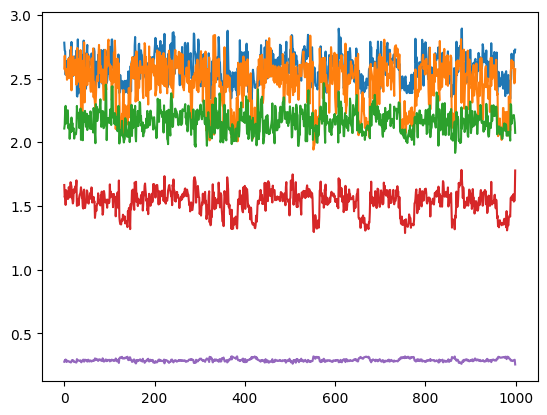

In [28]:
plt.plot(trace[0].position[0,:,:])
# plt.scatter(np.array([[i, v.squeeze()] for i, (k, v) in enumerate(test_data.items()) if k in inference_conditions]))
# plt.legend()